# NYC Apartment Search

_[Project prompt](https://docs.google.com/document/d/1BYVyFBDcTywdUlanH0ysfOrNWPgl7UkqXA7NeewTzxA/edit#heading=h.bpxu7uvknnbk)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add code as you wish._

_**All code below should be consider "pseudo-code" - not functional by itself, and only an idea of a possible approach.**_

## Setup

In [1]:
# All import statements needed for the project, for example:

import json
import pathlib
import urllib.parse
import geoalchemy2 as gdb
from geoalchemy2 import WKTElement
from geoalchemy2 import Geometry
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import shapely
import sqlalchemy as db
from sqlalchemy import create_engine, text
import numpy as np
from shapely import wkt
import psycopg2

from sqlalchemy.orm import declarative_base

In [2]:
# Any constants you might need; some have been added for you

# Where data files will be read from/written to - this should already exist
DATA_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/data")
ZIPCODE_DATA_FILE = DATA_DIR / "nyc_zipcodes" / "nyc_zipcodes.shp" 
ZILLOW_DATA_FILE = DATA_DIR / "zillow_rent_data.csv"


NYC_DATA_APP_TOKEN = "ViHT9fZpI3IQw23Bqm2tTgCVE"
BASE_NYC_DATA_URL = "https://data.cityofnewyork.us/"
NYC_DATA_311 = "erm2-nwe9.geojson"
NYC_DATA_TREES = "5rq2-4hqu.geojson"

DB_NAME = "Final_project"
DB_USER = "postgres"
DB_PASSWORD = "yq001018"
DB_HOST = "localhost"  
DB_PORT = "5432" 

DB_URL = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
DB_SCHEMA_FILE = "schema.sql"

# directory where DB queries for Part 3 will be saved
QUERY_DIR = pathlib.Path("/Users/sun/Documents/GitHub/Final-Project-Group34/queries")


endpoint_331 = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_311}?\
$select=unique_key,created_date,incident_zip,complaint_type&\
$where= created_date between '2015-01-01' and'2023-10-01'&$limit=24336506&\
$$app_token={NYC_DATA_APP_TOKEN}"

endpoint_trees = f"{BASE_NYC_DATA_URL}resource/{NYC_DATA_TREES}?"\
                 "$select=tree_id,the_geom,zipcode,zip_city,health,spc_common&"\
                 f"$$app_token={NYC_DATA_APP_TOKEN}&$limit=65000 &$where= zip_city='New York'"

## Part 1: Data Preprocessing

In [3]:
def load_and_clean_zipcodes():
    zipcodes_df = gpd.read_file(ZIPCODE_DATA_FILE)
    zipcodes_df = zipcodes_df[zipcodes_df['PO_NAME'] == 'New York']
    zipcodes_df[["ZIPCODE","geometry"]]
    return zipcodes_df[["ZIPCODE","geometry"]]

In [4]:
def download_and_clean_311_data():
    content = requests.get(endpoint_331)
    data_331 = gpd.read_file(content.text)
    return data_331[["unique_key","created_date","incident_zip","complaint_type"]]

In [5]:
def download_and_clean_tree_data():
    content = requests.get(endpoint_trees)
    data_tree = gpd.read_file(content.text).reset_index()
    return data_tree

In [6]:
def load_and_clean_zillow_data():
    zillow_df = gpd.read_file(ZILLOW_DATA_FILE)
    zillow_df = zillow_df[zillow_df['City'] == 'New York']
    date_columns = [col for col in zillow_df if col >= '2015-01-31' and col <= '2023-09-30']

    for col in date_columns:
        zillow_df[col] = pd.to_numeric(zillow_df[col], errors='coerce')
    
    zillow_df['AverageRent'] = zillow_df[date_columns].mean(axis=1, skipna=True,)
    zillow_df.rename(columns={'RegionName': 'Zip_code'},inplace=True)
    return zillow_df[["RegionID",'Zip_code',"AverageRent"] + date_columns]

In [7]:
def load_all_data():
    geodf_zipcode_data = load_and_clean_zipcodes()
    geodf_311_data = download_and_clean_311_data()
    geodf_tree_data = download_and_clean_tree_data()
    df_zillow_data = load_and_clean_zillow_data()
    return (
        geodf_zipcode_data,
        geodf_311_data,
        geodf_tree_data,
        df_zillow_data
    )

In [10]:
geodf_zipcode_data, geodf_311_data, geodf_tree_data, df_zillow_data = load_all_data()

In [13]:
# Show basic info about each dataframe
geodf_zipcode_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 110 entries, 21 to 262
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ZIPCODE   110 non-null    object  
 1   geometry  110 non-null    geometry
dtypes: geometry(1), object(1)
memory usage: 2.6+ KB


In [14]:
# Show first 5 entries about each dataframe
geodf_zipcode_data.rename(columns={'ZIPCODE': 'zipcode'}, inplace=True)
geodf_zipcode_data.head()

,zipcode,geometry
21,10034,"POLYGON ((1006203.169 257345.657, 1006214.666 ..."
22,10033,"POLYGON ((1003020.865 256049.162, 1003096.046 ..."
24,10040,"POLYGON ((1002564.135 253724.773, 1002596.698 ..."
32,10032,"POLYGON ((998935.853 249154.260, 998945.457 24..."
36,10031,"POLYGON ((1000830.039 241801.590, 1000913.103 ..."


In [15]:
geodf_311_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 355000 entries, 0 to 354999
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   unique_key      355000 non-null  object        
 1   created_date    355000 non-null  datetime64[ns]
 2   incident_zip    348105 non-null  object        
 3   complaint_type  355000 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 10.8+ MB


In [16]:
geodf_311_data.head()

,unique_key,created_date,incident_zip,complaint_type
0,58974915,2023-09-30 23:59:58,11226,Noise - Street/Sidewalk
1,58972386,2023-09-30 23:59:38,11361,Noise - Residential
2,58973465,2023-09-30 23:59:35,10002,Noise - Commercial
3,58974769,2023-09-30 23:59:34,11435,Noise - Residential
4,58968700,2023-09-30 23:59:28,11226,Noise - Residential


In [17]:
geodf_tree_data.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 64488 entries, 0 to 64487
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       64488 non-null  int64   
 1   health      61495 non-null  object  
 2   zipcode     64488 non-null  object  
 3   tree_id     64488 non-null  object  
 4   spc_common  61496 non-null  object  
 5   zip_city    64488 non-null  object  
 6   geometry    64488 non-null  geometry
dtypes: geometry(1), int64(1), object(5)
memory usage: 3.4+ MB


In [18]:
geodf_tree_data.head()

,index,health,zipcode,tree_id,spc_common,zip_city,geometry
0,0,Good,10023,190422,honeylocust,New York,POINT (-73.98495 40.77005)
1,1,Good,10023,190426,honeylocust,New York,POINT (-73.98534 40.77021)
2,2,Good,10019,208649,American linden,New York,POINT (-73.98730 40.76272)
3,3,Good,10021,193310,honeylocust,New York,POINT (-73.96046 40.77217)
4,4,Fair,10024,199760,willow oak,New York,POINT (-73.98096 40.78209)


In [19]:
df_zillow_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 4 to 6721
Columns: 108 entries, RegionID to 2023-09-30
dtypes: float64(106), object(2)
memory usage: 123.5+ KB


In [20]:
df_zillow_data.head()

,RegionID,Zip_code,AverageRent,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30,2023-05-31,2023-06-30,2023-07-31,2023-08-31,2023-09-30
4,62093,11385,2476.923402,NaN,2087.527084,NaN,2149.924252,2166.263698,2148.992886,2190.098591,...,2935.808220,2895.699421,2873.209025,2881.906361,2913.546218,2963.964134,3005.735342,3034.413822,3064.476503,3079.585783
6,62019,11208,2560.469803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2508.670432,2588.030194,2613.790654,2585.561351,2633.200754,2672.038493,2806.918757,2765.224364,2737.547470,2728.733333
12,62046,11236,2323.980013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2285.460026,2362.500000
13,61807,10467,1861.072982,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2145.642295,2155.617718,2172.346611,2160.962748,2110.533203,2180.323655,2276.372290,2334.204728,2353.686402,2423.888889
14,62085,11373,2084.549636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2199.459063,2255.604528,2262.101623,2271.514956,2250.182334,2231.959479,2257.413993,2247.592851,2302.557354,2292.994444


## Part 2: Storing Data

In [17]:
#!createdb Final_project

In [18]:
#!psql --dbname Final_project -c 'CREATE EXTENSION postgis;'

In [21]:
# Connect to pgsl
conn = psycopg2.connect(f"dbname={DB_NAME} user={DB_USER}")
cur = conn.cursor()

### Creating Tables


These are just a couple of options to creating your tables; you can use one or the other, a different method, or a combination.

In [22]:
engine = db.create_engine(DB_URL)

In [27]:
# if using SQL (as opposed to SQLAlchemy), define the SQL statements to create your 4 tables
ZIPCODE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS zip_codes (
        zipcode VARCHAR,
        geometry GEOMETRY
    )
    """

NYC_311_SCHEMA = """
    CREATE TABLE IF NOT EXISTS nyc_311 (
        unique_key INTEGER PRIMARY KEY,
        created_date DATE,
        incident_zip VARCHAR,
        complaint_type VARCHAR
    )
    """

NYC_TREE_SCHEMA = """
    CREATE TABLE IF NOT EXISTS trees (
        tree_id INTEGER PRIMARY KEY,
        zipcode VARCHAR,
        geometry GEOMETRY
    )
    """

date_col = [f'"{col}" REAL' for col in df_zillow_data.columns if col.startswith('20')]

ZILLOW_SCHEMA = f"""
CREATE TABLE IF NOT EXISTS rent (
    RegionID INTEGER PRIMARY KEY,
    Zip_code VARCHAR,
    AverageRent REAL,
    {', '.join(date_col)}
)
"""

In [28]:
# create that required schema.sql file
with open(DB_SCHEMA_FILE, "w") as f:
    f.write(ZIPCODE_SCHEMA)
    f.write(NYC_311_SCHEMA)
    f.write(NYC_TREE_SCHEMA)
    f.write(ZILLOW_SCHEMA)

In [29]:
# If using SQL (as opposed to SQLAlchemy), execute the schema files to create tables
with cur:
    cur.execute(ZIPCODE_SCHEMA)
    cur.execute(NYC_311_SCHEMA)
    cur.execute(NYC_TREE_SCHEMA)
    cur.execute(ZILLOW_SCHEMA)

conn.commit()

### Add Data to Database

These are just a couple of options to write data to your tables; you can use one or the other, a different method, or a combination.

#### Option 1: SQL

In [29]:
def write_dataframes_to_table(tablename_to_dataframe):
    for tablename, dataframe in tablename_to_dataframe.items():
        if 'geometry' in dataframe.columns:
            temp_df = dataframe
            temp_df['the_geom'] = temp_df['geometry'].apply(lambda geom: WKTElement(geom.wkt, srid=4326) if geom is not None else None)
            temp_df.drop('geometry',axis=1,inplace=True)
            temp_df.to_sql(tablename, engine, if_exists='replace', index=False, 
                             dtype={'the_geom': Geometry('GEOMETRY', srid=4326)}) 
            
        else:
            dataframe.to_sql(tablename, engine, if_exists='replace', index=False)

In [30]:
tablename_to_dataframe = {
    "zip_codes": geodf_zipcode_data,
    "nyc_311": geodf_311_data,
    "trees": geodf_tree_data,
    "rent": df_zillow_data,
}

In [31]:
write_dataframes_to_table(tablename_to_dataframe)

In [32]:

cur = conn.cursor() #connect to cursor
cur.execute("SELECT * FROM rent LIMIT 10;")

In [33]:
rows = cur.fetchall()
for row in rows:
    print(row)

('62093', '11385', 2476.923401784201, None, 2087.527084354236, None, 2149.9242522176696, 2166.2636978114047, 2148.9928856397355, 2190.098590663059, 2264.9667154092986, 2297.9009165932744, 2267.061704891128, 2225.8900597492384, 2188.28767356946, 2189.3470387304583, 2255.28377072397, 2267.36974971921, 2296.9999529002107, 2272.544133770503, 2282.492009139728, 2313.009450540561, 2334.460177809979, 2378.91044942648, 2397.294201281098, 2357.959208546377, 2338.575627078289, 2319.1708873161115, 2344.361311624835, 2345.0766325036943, 2333.9067668124885, 2343.39574731235, 2332.2285297605845, 2351.643160135104, 2346.7606154580044, 2391.4482353885464, 2366.9753754223325, 2376.8141179668, 2349.812498667744, 2340.667650568317, 2309.4949644028893, 2311.3902280710354, 2326.9186873489643, 2358.4724286814003, 2367.4564389822563, 2382.3846710777743, 2386.107852213686, 2401.5251931345742, 2419.898399284853, 2420.804473714676, 2420.254365648151, 2400.882443808336, 2419.3924529994074, 2407.5373017488805, 24

In [34]:
with engine.connect() as conn:
    rows = conn.execute("SELECT * FROM trees LIMIT 10").fetchall()
    for row in rows:
        print(row["zipcode"])

10023
10023
10019
10021
10024
10002
10023
10023
10023
10023


In [35]:
with engine.connect() as conn:
    result = conn.execute(db.text("SELECT COUNT(*) FROM nyc_311"))
    for row, in result:
        print(row)

355000


In [36]:
cur.execute("SELECT * FROM zip_codes LIMIT 10;")

In [37]:
rows = cur.fetchall()
for row in rows:
    print(row)

('10034', '0103000020E61000000100000093040000003F8856F6B42E410002C1400D6A0F41803502550DB52E410018A6880D6A0F4180B4C90E18B52E4100B64458126A0F4180114C3B22B52E41005217421A6A0F4180FCF6D134B52E410016C444336A0F4100FEEACD52B52E4100124AB66E6A0F41004261E180B52E4100309763D66A0F410079D11CB4B52E410048C07F4B6B0F4180511300D8B52E41005072DEA26B0F41006311C0E6B52E41004CEE49CE6B0F4100B9DD91F5B52E4100C8F5FB056C0F4100810B3F04B62E41005684C7476C0F41808D99C71BB62E4100E2063BBC6C0F41804F81D235B62E41007C20D03B6D0F4100DE8C2E44B62E4100CEE60D8D6D0F410097200E4AB62E4100FE9E6CB56D0F4100F41DCD4EB62E410096F69ADC6D0F4180357C7C52B62E4100CA672B036E0F410083836B5DB62E410098881ED16E0F410095854267B62E410012BFC9C66F0F41004BD0A875B62E4100AC301C51710F418085D90277B62E41007609B89A710F41005A3A7376B62E41001680F8E9710F4100CA73FA73B62E410010410940720F410062CA7A6FB62E4100523007A1720F4180ABBC736CB62E4100248E0ED1720F4100BA039768B62E4100D846C3FF720F4100CC94F463B62E41007E2B632C730F41001CB99B5EB62E4100DA695A56730F4180F9EEA058B62E4100A87F127D7

## Part 3: Understanding the Data

In [38]:
# Helper function to write the queries to file
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query 1

In [ ]:
QUERY_1_FILENAME = QUERY_DIR / "FILL_ME_IN"

QUERY_1 = """
FILL_ME_IN
"""

In [ ]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_1))
    for row in result:
        print(row)

In [ ]:
write_query_to_file(QUERY_1, QUERY_1_FILENAME)

### Query 2

In [39]:
QUERY_2_FILENAME = QUERY_DIR / "Q2.sql"
QUERY_2 = """
SELECT zipcode, COUNT(tree_id) AS total_trees
FROM trees
GROUP BY zipcode
ORDER BY total_trees DESC
LIMIT 10;
"""

In [40]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_2))
    for row in result:
        print(row)

('10025', 3696)
('10024', 3311)
('10027', 2992)
('10014', 2591)
('10031', 2587)
('10029', 2423)
('10002', 2265)
('10023', 2260)
('10032', 2217)
('10128', 2136)


In [41]:
write_query_to_file(QUERY_2, QUERY_2_FILENAME)

### Query 3

In [42]:
QUERY_3_FILENAME = QUERY_DIR / "Q3.sql"
QUERY_3 = """
SELECT t.zipcode, 
       ROUND(CAST(r."2023-08-31" AS NUMERIC), 2) AS August2023
FROM trees t
JOIN rent r ON t.zipcode = r."Zip_code"
GROUP BY t.zipcode, r."2023-08-31"
ORDER BY COUNT(t.tree_id) DESC
LIMIT 10;
"""

In [43]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_3))
    for row in result:
        print(row)

('10025', Decimal('4037.77'))
('10024', Decimal('3797.94'))
('10027', Decimal('3235.99'))
('10014', Decimal('4899.07'))
('10031', Decimal('2967.04'))
('10029', Decimal('2915.94'))
('10002', Decimal('4078.87'))
('10023', Decimal('4370.07'))
('10032', Decimal('2657.76'))
('10128', Decimal('3565.40'))


In [44]:
write_query_to_file(QUERY_3, QUERY_3_FILENAME)

### Query 4

### Query 5

In [45]:
QUERY_5_FILENAME = QUERY_DIR / "Q5.sql"
QUERY_5 = """
SELECT z.zipcode, COUNT(t.tree_id) AS total_trees
FROM trees t
JOIN zip_codes z ON ST_Contains(z.the_geom, t.the_geom)
GROUP BY z.zipcode
ORDER BY total_trees DESC;
"""

In [46]:
with engine.connect() as conn:
    result = conn.execute(db.text(QUERY_5))
    for row in result:
        print(row)

In [47]:
write_query_to_file(QUERY_5, QUERY_5_FILENAME)

In [89]:
with engine.connect() as conn:
    result = conn.execute("SELECT column_name, data_type FROM information_schema.columns WHERE table_name = 'trees';")
    for row in result:
        print(row)

('index', 'bigint')
('the_geom', 'USER-DEFINED')
('zipcode', 'text')
('spc_common', 'text')
('zip_city', 'text')
('tree_id', 'text')
('health', 'text')


### Query 6

## Part 4: Visualizing the Data

### Visualization 1

In [48]:
def plot_top_3_complaints(dataframe1):
    figure, axes = plt.subplots(figsize=(20, 10))
    axes.bar(dataframe1['complaint_type'], dataframe1['complaint_count'])

    axes.set_title("Top 3 Complaint Types for October 1st, 2022 to September 30th, 2023 ")
    axes.set_xlabel("Complaint Type")
    axes.set_ylabel("Complaint Count")
    
    plt.show()

In [49]:
def get_data_for_visual_1():
    V1 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 3;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V1))
        dataframe1 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe1

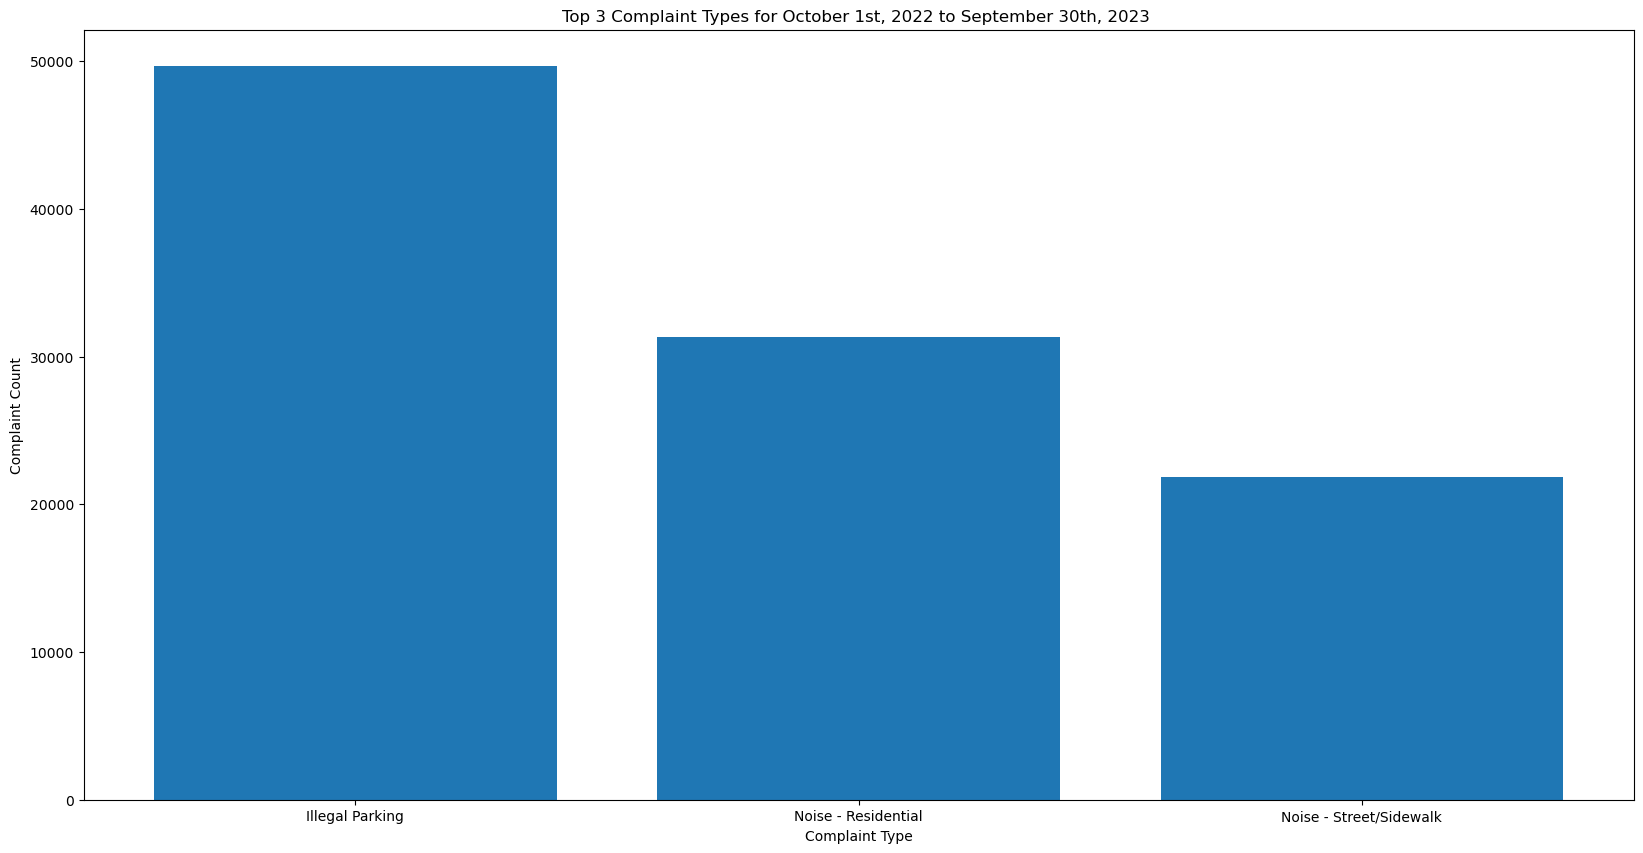

In [50]:
some_dataframe1 = get_data_for_visual_1()
plot_top_3_complaints(some_dataframe1)

### Visualization 2

In [51]:
def plot_top_10_complaints(dataframe2):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    complaint_types = dataframe2['complaint_type']
    complaint_counts = dataframe2['complaint_count']
    axes.bar(complaint_types, complaint_counts)
    axes.set_title('Top 10 Complaints in Zip Code 10027')
    axes.set_xlabel('Complaint Type')
    axes.set_ylabel('Complaint Count')
    
    plt.show()

In [52]:
def get_data_for_visual_2():
    V2 = """
    SELECT complaint_type, COUNT(unique_key) AS complaint_count
    FROM nyc_311
    WHERE incident_zip = '10027' AND created_date BETWEEN '2018-10-01' AND '2023-09-30'
    GROUP BY complaint_type
    ORDER BY complaint_count DESC
    LIMIT 10;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V2))
        dataframe2 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe2

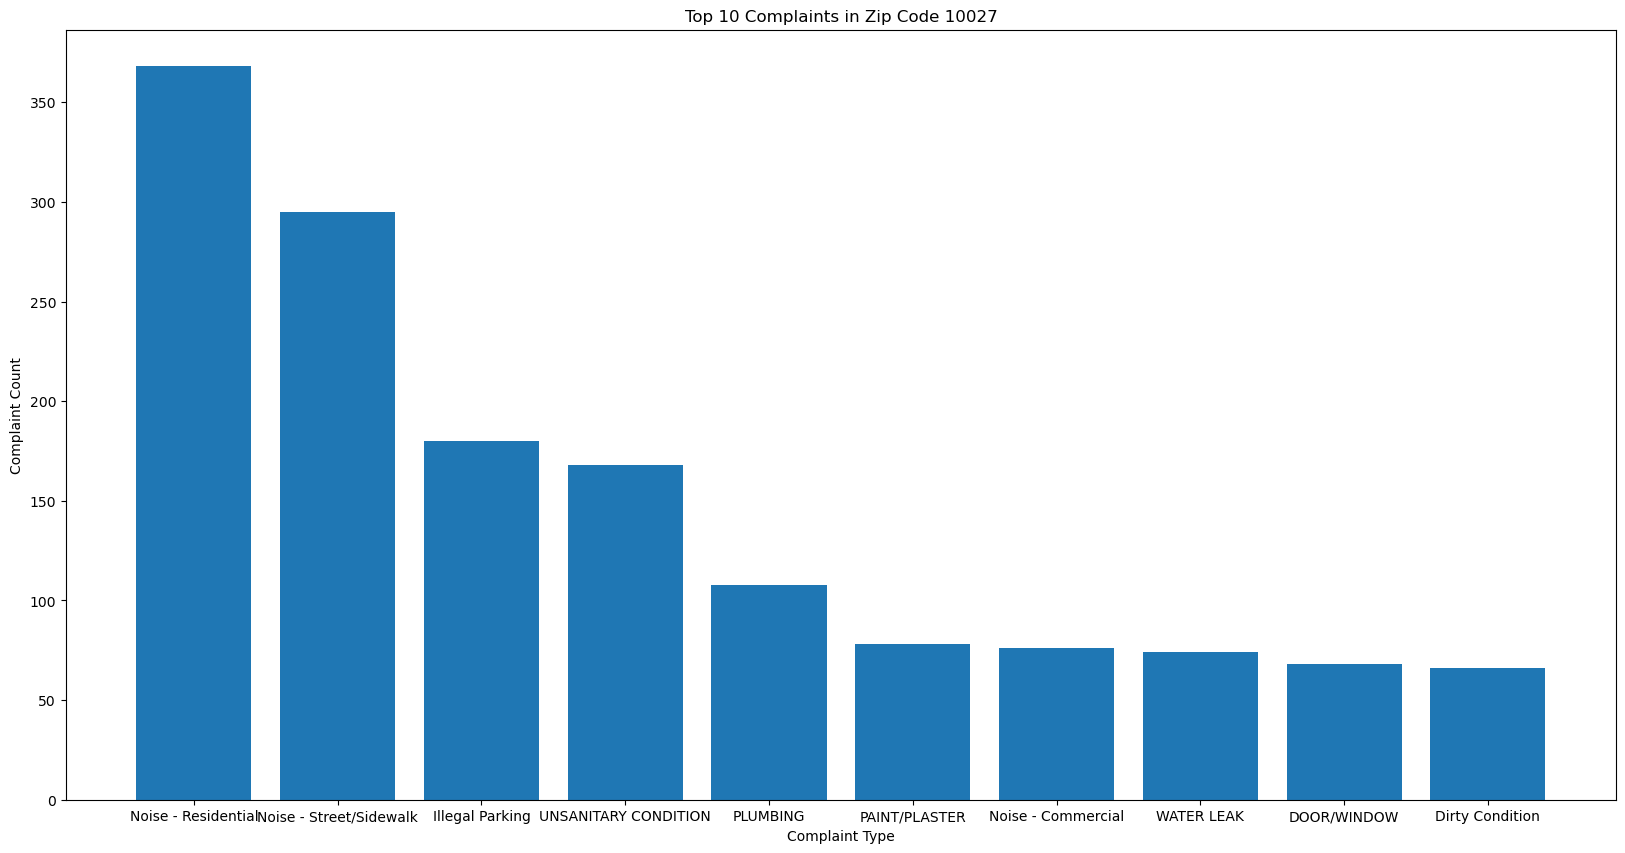

In [53]:
some_dataframe2 = get_data_for_visual_2()
plot_top_10_complaints(some_dataframe2)

### Visualization 3

In [54]:
def plot_rent_trees_complaints(dataframe3):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 20), sharex=True)

    # Rent & Tree
    ax1.scatter(dataframe3['AverageRent'], dataframe3['TreeCount'])
    ax1.set_title("Average Rent vs Tree Count")
    ax1.set_ylabel("Tree Count")

    # Rent & Complaints
    ax2.scatter(dataframe3['AverageRent'], dataframe3['ComplaintCount'])
    ax2.set_title("Average Rent vs Number of Complaints")
    ax2.set_xlabel("Average Rent")
    ax2.set_ylabel("Complaint Count")

    plt.show()

In [55]:
def get_data_for_visual_3():
    V3 = """
    WITH RentData AS (
    SELECT Zip_code,
           。。。
    FROM rent
    GROUP BY Zip_code
    ),

    TreeData AS (
        SELECT zipcode, COUNT(tree_id) AS TreeCount
        FROM trees
        GROUP BY zipcode
    ),

    ComplaintData AS (
        SELECT incident_zip, COUNT(unique_key) AS ComplaintCount
        FROM nyc_311
        WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY incident_zip
    )

    SELECT r.Zip_code, r.AverageRent, t.TreeCount, c.ComplaintCount
    FROM RentData r
    LEFT JOIN TreeData t ON r.Zip_code = t.zipcode
    LEFT JOIN ComplaintData c ON r.Zip_code = c.zipcode;
    """
    with engine.connect() as conn:
        result = conn.execute(db.text(V3))
        dataframe3 = pd.DataFrame(result.fetchall(), columns=result.keys())
    return dataframe3

In [56]:
some_dataframe3 = get_data_for_visual_3()
plot_rent_trees_complaints(some_dataframe3)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "zip_code" does not exist
LINE 3:     SELECT Zip_code,
                   ^
HINT:  Perhaps you meant to reference the column "rent.Zip_code".

[SQL: 
    WITH RentData AS (
    SELECT Zip_code,
           。。。
    FROM rent
    GROUP BY Zip_code
    ),

    TreeData AS (
        SELECT zipcode, COUNT(tree_id) AS TreeCount
        FROM trees
        GROUP BY zipcode
    ),

    ComplaintData AS (
        SELECT incident_zip, COUNT(unique_key) AS ComplaintCount
        FROM nyc_311
        WHERE created_date BETWEEN '2015-01-01' AND '2023-09-30'
        GROUP BY incident_zip
    )

    SELECT r.Zip_code, r.AverageRent, t.TreeCount, c.ComplaintCount
    FROM RentData r
    LEFT JOIN TreeData t ON r.Zip_code = t.zipcode
    LEFT JOIN ComplaintData c ON r.Zip_code = c.zipcode;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

### Visualization 4

In [57]:
def plot_rent_vs_complaints(dataframe4):
    dataframe4['Boxplot'] = pd.cut(dataframe4['Rent'], bins=np.arange(0, dataframe4['Rent'].max() + 1000, 1000), right=False)
    
    plt.figure(figsize=(20, 10))
    dataframe4.boxplot(column='complaint_count', by='Boxplot', grid=False)
    plt.title('Rent vs Number of 311 Complaints')
    plt.xlabel('Rent')
    plt.ylabel('Complaint Count')

    plt.show()

In [58]:
def get_data_for_visual_4():
    V4 = """
    SELECT r."Zip_code", r."2023-09-30" AS Rent, COUNT(n.unique_key) AS complaint_count
    FROM nyc_311 n
    JOIN rent r ON n.incident_zip = r."Zip_code"
    WHERE n.created_date BETWEEN '2022-10-01' AND '2023-09-30'
    GROUP BY r."Zip_code", r."2023-09-30"
    ORDER BY r."2023-09-30";
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V4))
        dataframe4 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe4

In [59]:
some_dataframe4 = get_data_for_visual_4()
plot_rent_vs_complaints(some_dataframe4)

KeyError: 'Rent'

### Visualization 5

In [60]:
def plot_recent_311_incidents(dataframe5):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    dataframe5.plot(ax=ax, marker='o', color='red', markersize=5)
    ax.set_title("Recent 311 Incidents in Immediate Area")
    plt.show()

In [61]:
def get_data_for_visual_5():
    V5 = """
    SELECT n.unique_key, n.created_date, n.incident_zip, n.complaint_type, z.geometry
    FROM nyc_311 n
    JOIN zip_codes z ON n.incident_zip = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DistanceSphere(z.geometry, ST_MakePoint(part3q6的经度, 纬度)) <= 1000;
    """
    
    with engine.connect() as conn:
        result = conn.execute(db.text(V5))
        dataframe5 = pd.DataFrame(result.fetchall(), columns=result.keys())

    return dataframe5

In [62]:
some_dataframe5 = get_data_for_visual_5()
plot_recent_311_incidents(some_dataframe5)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column z.geometry does not exist
LINE 2: ...n.created_date, n.incident_zip, n.complaint_type, z.geometry
                                                             ^

[SQL: 
    SELECT n.unique_key, n.created_date, n.incident_zip, n.complaint_type, z.geometry
    FROM nyc_311 n
    JOIN zip_codes z ON n.incident_zip = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND ST_DistanceSphere(z.geometry, ST_MakePoint(part3q6的经度, 纬度)) <= 1000;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)

### Visualization 6

In [63]:
def plot_trees_and_requests(tree_df, request_df):
    fig, ax = plt.subplots(figsize=(10, 10))

    tree_df.plot(ax=ax, marker='o', color='green', markersize=5, label='Trees')

    request_df.plot(ax=ax, marker='x', color='red', markersize=5, label='New Tree Requests')
    ax.legend()
    ax.set_title('Trees and New Tree Requests in NYC')
    
    plt.show()

In [64]:
def get_data_for_visual_6():
    V6_trees = """
    SELECT tree_id, geometry
    FROM trees;
    """

    V6_complaints = """
    SELECT n.unique_key, n.created_date, n.incident_zip, n.complaint_type, z.geometry
    FROM nyc_311 n
    JOIN zip_codes z ON n.incident_zip = z.zipcode
    WHERE n.created_date BETWEEN '2023-01-01' AND '2023-09-30'
    AND complaint_type = 'New Tree Request';
    """

    with engine.connect() as conn:
        trees_result = conn.execute(db.text(V6_trees))
        complaints_result = conn.execute(db.text(V6_complaints))

        trees_df = gpd.GeoDataFrame(trees_result.fetchall(), columns=trees_result.keys())
        complaints_df = gpd.GeoDataFrame(complaints_result.fetchall(), columns=complaints_result.keys())

    return trees_df, complaints_df

In [65]:
some_dataframe6 = get_data_for_visual_6()
plot_trees_and_requests(some_dataframe6)

ProgrammingError: (psycopg2.errors.UndefinedColumn) column "geometry" does not exist
LINE 2:     SELECT tree_id, geometry
                            ^

[SQL: 
    SELECT tree_id, geometry
    FROM trees;
    ]
(Background on this error at: https://sqlalche.me/e/14/f405)